In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import pywt
import xrscipy.signal.extra as dsp_extra
from typing import List, Dict
from collections import defaultdict
import os
import math

import datetime
import calendar 

import colormaps as cmaps
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib import cm 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize 
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import ScalarFormatter
import cmocean
import matplotlib.dates as mdates


import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import fftconvolve
from scipy.ndimage import convolve1d

from eofs.xarray import Eof
from scipy.signal import butter, filtfilt
from scipy.signal import firwin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from helper_functions import *

/home/b/b382999/.conda/envs/jisesh_env/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
diri = ''
diro = '/weather_regimes_plots/'
fili = '<INPUT Z500 Raw file>'

lati = 30
latf = 90
loni = -80
lonf = 40

# Change this as required
strt = '1960-01-01'
last = '2023-12-31'

f = xr.open_dataset(diri+fili).sel(time=slice(strt,last))
f

<xarray.Dataset>
Dimensions:  (time: 93504, lat: 65, lon: 201)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 ... 2023-12-31T18:00:00
    plev     float64 ...
  * lat      (lat) float64 25.22 26.22 27.22 28.22 ... 86.22 87.22 88.22 89.22
  * lon      (lon) float64 -120.0 -119.0 -118.0 -117.0 ... 77.0 78.0 79.0 80.0
Data variables:
    zg       (time, lat, lon) float32 ...
Attributes:
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    history:        Tue Mar 07 22:04:58 2023: cdo -s -z zip_9 mergetime /scra...
    institution:    European Centre for Medium-Range Weather Forecasts
    Conventions:    CF-1.6
    license:        Contains modified Copernicus Atmosphere Monitoring Servic...
    tracking_id:    d5b13485-16f3-5f65-8dfd-cf03615bcc01
    creation_date:  2023-03-07T19:31:44Z
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...

In [3]:
%%time
# Data
z = f.zg

# Compute smoothed 6-hourly climatology using hourofyear
z_clim_smooth = compute_6h_climatology_hourofyear(z, window_days=90)

# Compute anomalies
# Redefine hourofyear in six-hourly units to match the climatology
hourofyear_vals = ((z.time.dt.dayofyear - 1) * 4 + (z.time.dt.hour // 6)).values
z_6h = z.assign_coords(hourofyear=("time", hourofyear_vals))

# Compute anomalies by subtracting the climatology
# Ensure that both 'z_6h' and 'z_clim_smooth' are grouped by the same 'hourofyear'
zh_anomaly = z_6h.groupby("hourofyear") - z_clim_smooth

CPU times: user 11.8 s, sys: 24.8 s, total: 36.6 s
Wall time: 4min 29s


In [4]:
%%time
filter_width = 10 # in days
cutoff = 10 # in days 
sigma = 1.5

# Apply low-pass filter
z_lowPass = lanczos_filter_10_day_lowpass(dataarray=zh_anomaly, 
                                          timesteps_per_day=4,   # 6-hourly data => 4 timesteps per day
                                          num_passes=2, # number of times to be passed through the filter -> helps reduce data leakage
                                          filter_width_days=filter_width,
                                          filter_cutoff_days=cutoff,
                                          sigma=sigma
                                         )

CPU times: user 39.1 s, sys: 3.5 s, total: 42.6 s
Wall time: 42.8 s


In [7]:
%%time
# Compute temporal std 
temporal_std = compute_normalization(z_lowPass, window_days=15) # window_days -> half_window length in days  

# # Save computed temporal standard deviation (uncomment if needed)
# temporal_std.to_netcdf(temporal_std_path)
# print("temporal_std computed and saved to:", temporal_std_path)

CPU times: user 13.6 s, sys: 165 ms, total: 13.7 s
Wall time: 13.8 s


In [8]:
# Compute spatial mean of temporal standard deviation across all gridpoints
spatial_std_mean = temporal_std.mean(dim=["lat", "lon"])

In [9]:
# Normalize using groupby with matching 'hourofyear'
z_normalized = z_lowPass.sel(lat=slice(lati,latf), lon=slice(loni, lonf)).groupby("hourofyear") / spatial_std_mean

In [10]:
# Convert lat to radians
lat_radians = np.deg2rad(z_normalized.lat)

# Typically use sqrt(cos(lat)) or cos(lat)
lat_weights_1d = np.sqrt(np.cos(lat_radians))

# Create a 2D array of weights [lat, lon] by broadcasting
# (lon dimension just repeats the weights)
weights_2d = lat_weights_1d.broadcast_like(z_normalized.isel(time=0))

# Weighted data array
z_normalized = z_normalized * weights_2d  # shape: (time, lat, lon)

# The following cell contains steps to compute Cluster means from scratch. Use this if you need to compute Cluster means based on non-ERA5 data or if you want a cutsom number of clusters (!=7). Otherwise use ERA5-based cluster means provided with the package.

In [11]:
# %%time
# # Standardize the data
# data_scaler = StandardScaler()
# z_normalized_scaled = data_scaler.fit_transform(z_normalized.sel(lat=slice(lati,latf), lon=slice(loni, lonf)).values.reshape(z.shape[0], -1))

# # Perform PCA (Equivalent to EOF Analysis)
# pca = PCA(n_components=4, svd_solver='randomized', whiten=False)
# pca.fit(z_normalized.values.reshape(z.shape[0], -1))


# # Extract the EOF modes (spatial patterns) and PCs (time series)
# eof_modes = pca.components_  # Shape: (n_modes, spatial_dim)
# principal_components = pca.transform(z_normalized.values.reshape(z.shape[0], -1))  # Shape: (time, n_modes)

# # Convert EOF modes to xarray DataArray
# eof_modes = xr.DataArray(
#     data=eof_modes.reshape(7, z_normalized.sel(lat=slice(lati,latf), lon=slice(loni, lonf)).shape[1], 
#                            z_normalized.sel(lat=slice(lati,latf), lon=slice(loni, lonf)).shape[2]), 
#     dims=("mode", "lat", "lon"),
#     coords={
#         "mode": np.arange(7),
#         "lat": z.sel(lat=slice(lati,latf), lon=slice(loni, lonf)).lat,
#         "lon": z.sel(lat=slice(lati,latf), lon=slice(loni, lonf)).lon
#     },
#     name="EOF_Modes"
# )

# # Variance explained by each EOF mode
# eigenvalues = pca.singular_values_
# mode_variance = pca.explained_variance_ratio_ * 100

# # Normalilze PCs
# pc_scaler = StandardScaler()
# pcs_normalized = pc_scaler.fit_transform(principal_components)

# # Compute 7 clusters. Change this if you wish to compute 
# kmeans = KMeans(n_clusters=7, n_init=20, random_state=42)
# clusters = kmeans.fit_predict(principal_components)
# dims_eof = eof_modes.shape

# cluster_means = compute_cluster_means(z500_anomaly=z_normalized, cluster_labels=cluster_labels, num_clusters=7)

# cluster_means_ds = xr.DataArray(
#     name='cluster_means', 
#     data=cluster_means.values, 
#     dims=cluster_means.dims,
#     coords=cluster_means.coords,
#     attrs={
#         "description": (
#             f"Cluster means version created with {strt[2:4]}-{last[2:4]} ERA5 data. "
#             f"Normalized with spatial mean of temporal stddev of 10-day lowpass (with filter width of {filter_width} days and sigma:{sigma}) "
#             f"filtered z500 anomalies. Latitudinal weighting applied after normalization as sqrt(cos(latitude)). "
#             f"PCA computed with non-scaled normalized and lat-scaled lowpass filtered z500 anomalies: "
#             f"Top 7 EOF modes explain {mode_variance[:7].sum():0.2f}% variance. "
#         )
#     }
# )
# # Save cluster means to disk if needed. Recommended to avoid repeated computation
# cluster_means_ds.to_netcdf("Add a path")

In [12]:
# Load ERA5 cluster means provided. If needed create new ones using the cell above.
diri_cluster = ''
fili_cluster = 'cluster_means_weather_regimes_7915.nc'

cluster_means = xr.open_dataset(diri_cluster+fili_cluster)
cluster_means

<xarray.Dataset>
Dimensions:        (lat: 60, lon: 121, cluster: 7)
Coordinates:
  * lat            (lat) float64 30.22 31.22 32.22 33.22 ... 87.22 88.22 89.22
  * lon            (lon) float64 -80.0 -79.0 -78.0 -77.0 ... 37.0 38.0 39.0 40.0
  * cluster        (cluster) <U4 'GL' 'ScTr' 'EuBL' 'AR' 'ScBL' 'ZO' 'AT'
Data variables:
    cluster_means  (cluster, lat, lon) float64 ...

In [13]:
# Compute IWR
Iwr = compute_iwr(z500_anomaly=z_normalized, cluster_means=cluster_means.cluster_means)

In [14]:
# Normalize IWRs
iwr_scaler = StandardScaler()
Iwr_norm = iwr_scaler.fit_transform(Iwr)
Iwr_norm = xr.DataArray(name='Iwr', data=Iwr_norm, dims=Iwr.dims, coords=Iwr.coords)

In [15]:
# Create IWR dataframe for regime detection.

# Create time index for IWRs
time_index = pd.date_range(start="1960-01-01 00:00", end="2023-12-31 18:00", freq="6H")

# Check if the number of rows matches the time index length
if len(time_index) != Iwr_norm.shape[0]:
    raise ValueError("The number of time points does not match the array's number of rows.")

# Create the DataFrame
columns = Iwr_norm.cluster#[f"{i}" for i in range(Iwr_norm.shape[1])]
iwr_df = pd.DataFrame(Iwr_norm, columns=columns)

# Add time index as a column or set as the index
iwr_df["time"] = time_index

# Display the DataFrame
iwr_df[:60]

,GL,ScTr,EuBL,AR,ScBL,ZO,AT,time
0,-1.021227,-0.933728,0.442460,-1.388523,0.499603,1.148694,0.862574,1960-01-01 00:00:00
1,-1.018281,-0.939487,0.449709,-1.382266,0.510572,1.140737,0.850549,1960-01-01 06:00:00
2,-1.012594,-0.951146,0.464026,-1.369969,0.532085,1.125249,0.827057,1960-01-01 12:00:00
3,-1.004061,-0.968531,0.484832,-1.351367,0.563068,1.102487,0.792758,1960-01-01 18:00:00
4,-0.992524,-0.991403,0.511297,-1.326091,0.601995,1.072812,0.748613,1960-01-02 00:00:00
5,-0.977772,-1.019492,0.542376,-1.293714,0.646990,1.036667,0.695852,1960-01-02 06:00:00
6,-0.959549,-1.052517,0.576859,-1.253793,0.695935,0.994541,0.635933,1960-01-02 12:00:00
7,-0.937557,-1.090219,0.613423,-1.205922,0.746602,0.946945,0.570497,1960-01-02 18:00:00
8,-0.911467,-1.132380,0.650691,-1.149787,0.796783,0.894380,0.501309,1960-01-03 00:00:00
9,-0.880929,-1.178837,0.687288,-1.085210,0.844421,0.837307,0.430195,1960-01-03 06:00:00


In [16]:
# Compute IWR stadnard deviation
sigma_iwr = Iwr_norm.std()

In [17]:
%%time
threshold = 1.0 * sigma_iwr.values # Change this if needed 
final_labels = identify_weather_regimes_grams(IWR=iwr_df, threshold=threshold, min_days=5, max_time_diff_days=100) # Hauser et. al 2023
# Rename to df_wr
df_wr = final_labels
# # Write to CSV file
# df_wr.to_csv('ERA5_WR_list_1960_2023.csv')

CPU times: user 641 ms, sys: 77 μs, total: 641 ms
Wall time: 644 ms


In [18]:
# Compute the value counts for the 'WR' column (now string labels)
value_counts = df_wr['WR'].value_counts()

# Calculate the percentage for each unique value in 'WR'
total_timesteps = len(df_wr)
percentage = (value_counts / total_timesteps) * 100

# Define the correct label order
label_order = ["AT", "ZO", "ScTr", "AR", "EuBL", "ScBL", "GL", "No"]

# Display the result sorted by the defined order
print(percentage.reindex(label_order))

AT      10.328970
ZO       9.938612
ScTr     9.995294
AR       9.443446
EuBL    10.087269
ScBL    11.241230
GL       8.956836
No      30.008342
Name: WR, dtype: float64


In [19]:
# Same as above, but for specific seasons/months

# Ensure 'time' column exists
if 'time' not in df_wr.columns:
    raise ValueError("The DataFrame must contain a 'time' column.")

# Convert 'time' to datetime
df_wr['time'] = pd.to_datetime(df_wr['time'], errors='coerce')

# Define months (here DJF) and filter
djf_months = [12, 1, 2]
df_djf = df_wr[df_wr['time'].dt.month.isin(djf_months)].copy()

# Compute value counts
value_counts = df_djf['WR'].value_counts()

# Calculate percentages
total_timesteps = len(df_djf)
percentage = (value_counts / total_timesteps) * 100

# Define desired label order
desired_order = ["AT", "ZO", "ScTr", "AR", "EuBL", "ScBL", "GL", "No"]

# Reindex to match desired order
percentage = percentage.reindex(desired_order).fillna(0)

# Display the result
print("WR Percentages for DJF Months:")
print(percentage)

WR Percentages for DJF Months:
AT      14.114439
ZO      13.872057
ScTr    11.045706
AR       9.604398
EuBL    10.110803
ScBL     7.933691
GL      10.236323
No      23.082583
Name: WR, dtype: float64


In [20]:
# Define new label order if needed, otherwise leave unchanged
ordered_labels = ["AT", "ZO", "ScTr", "AR", "EuBL", "ScBL", "GL", "No"]

# Reindex the percentage to match the label order
ordered_percentage = percentage.reindex(ordered_labels).fillna(0)

# Initialize a list to hold the 8 arrays
arrays = []

# Filter the time indices for DJF months
djf_indices = np.where(df_wr['time'].dt.month.isin([12, 1, 2]))[0]

# Loop through the ordered labels
for label in ordered_labels:
    # Get the indices where WR == label and time is in DJF
    indices = np.where((df_wr['WR'] == label) & np.isin(np.arange(len(df_wr)), djf_indices))[0]
    arrays.append(indices)

# Confirm you have 8 arrays
print(f"Number of arrays: {len(arrays)}")

Number of arrays: 8


In [21]:
# # Optionally print the arrays for inspection
# for mode, array in zip(ordered_percentage.index, arrays):
#     print(f"Indices for WR = {mode}: {array}")

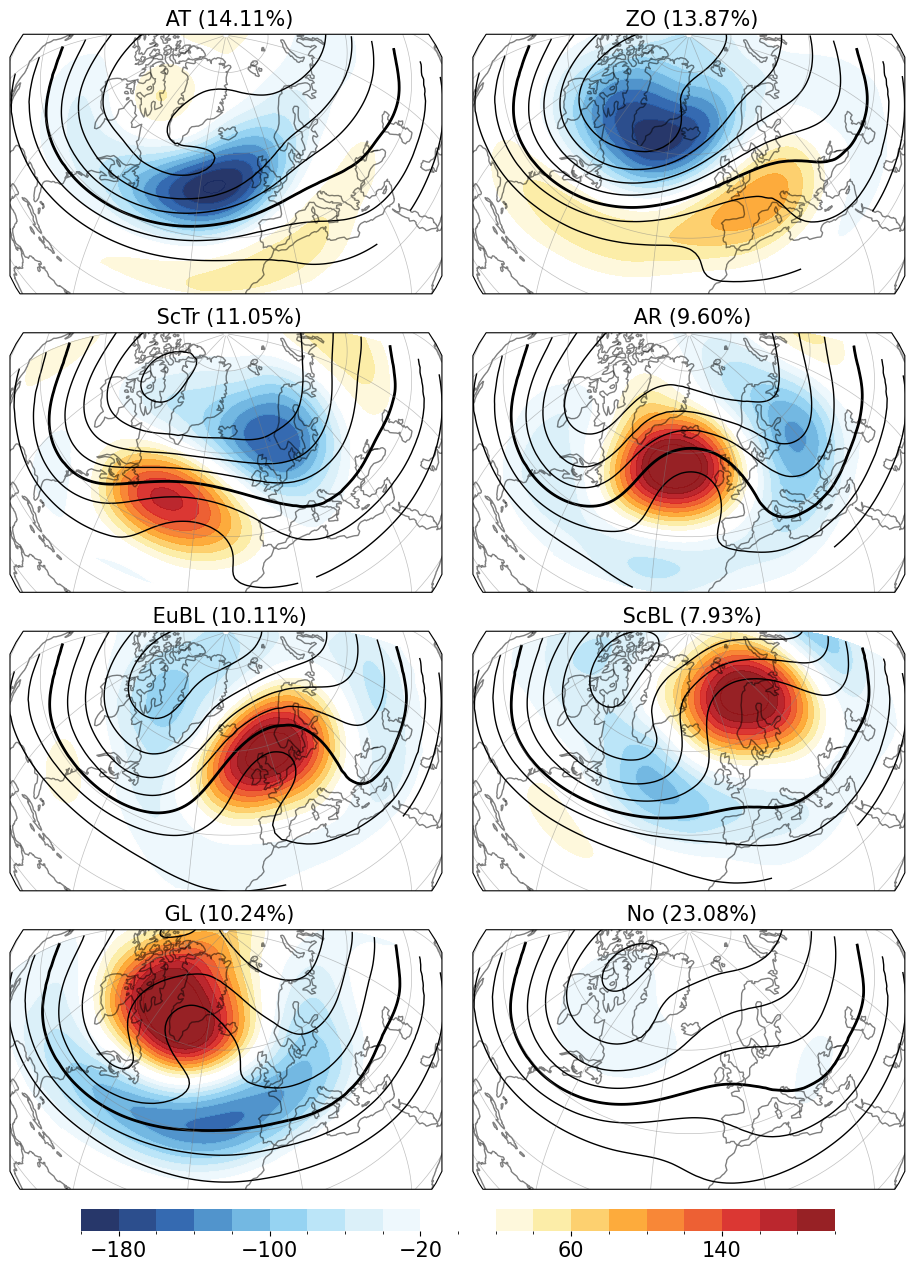

In [23]:
# Define the discrete levels
n_bins = 20
levels = np.linspace(-200, 200, n_bins + 1)  # 22 boundaries => 21 bins

# NCL-like colormap used in Grams et. al 2017. Here you can also add the new colorblind-friendly colormaps recommended
base_cmap = cmaps.BlueWhiteOrangeRed # This is the original colormap
# Get the colors as an array (each row is an RGBA color)
cmap_colors = base_cmap(np.linspace(0, 1, n_bins))

##########################################################
##################### USE IF NEEDED ######################
##########################################################
# Force the middle two bins to white
# if n_bins % 2 == 0:
#     mid = n_bins // 2
#     cmap_colors[mid-1:mid+1] = np.array([[1, 1, 1, 1],
#                                          [1, 1, 1, 1]])
# else:
#     mid = n_bins // 2
#     cmap_colors[mid] = np.array([1, 1, 1, 1])
##########################################################

# Build the ListedColormap from the modified colors.
custom_cmap = ListedColormap(cmap_colors)

# Create a discrete normalization (without extend)
norm = BoundaryNorm(levels, n_bins)

# The rest of your plotting code
# Define the desired order of the modes
desired_order = [0, 1, 2, 3, 4, 5, 6, -1]

# Initialize the subplots with Cartopy Orthographic projections.
fig, axes = plt.subplots(
    nrows=4, ncols=2, figsize=(13, 15), sharex=True, sharey=True,
    subplot_kw=dict(
        projection=ccrs.Orthographic(
            central_longitude=(f.lon[0] + f.lon[-1]).values * 0.5,
            central_latitude=(f.lat[0] + f.lat[-1]).values * 0.5
        )
    ),
    gridspec_kw={'wspace': -0.15, 'hspace': 0.15}
)

# Set the overall figure background color
fig.patch.set_facecolor('white')

axes = axes.flatten()

# Tick locations for the colorbar
ticks = np.arange(-180, 240, 80)

# Levels for additional contouring
level_contour = np.arange(5040, 6000, 120)

# Iterate through each mode in the desired order and plot
zg_anom_full = []
zg_raw_full = []
for i, mode in enumerate(desired_order):
    ax = axes[i]
    
    # Set the axis background color to white
    ax.set_facecolor('white')
    
    # Compute the mean for the current mode (assumes z_lowPass, z, arrays, and f are defined)
    data_to_plot = z_lowPass.isel(time=arrays[mode]).mean('time')
    zg_anom_full.append(data_to_plot)
    data_to_contour = z.isel(time=arrays[mode]).mean('time')
    zg_raw_full.append(data_to_contour)
    
    # Plot the filled contours using the discrete colormap and normalization.
    img = data_to_plot.plot.contourf(
        levels=levels,
        # cmap='RdBu_r',
        cmap=custom_cmap,  # custom colormap
        norm=norm,         # normalization
        ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        alpha=0.95,
    )
    
    # Add contour lines from the original data.
    cont = ax.contour(
        data_to_contour.lon,
        data_to_contour.lat,
        data_to_contour.values,
        levels=level_contour,
        colors='black',
        linestyles='solid',
        linewidths=1.0,
        transform=ccrs.PlateCarree(),
    )

    cont2 = ax.contour(
        data_to_contour.lon,
        data_to_contour.lat,
        data_to_contour.values,
        levels=[5520,],
        colors='black',
        linestyles='solid',
        linewidths=2.0,
        transform=ccrs.PlateCarree(),
    )

    # Set title with percentage for the current mode (assumes ordered_percentage is defined)
    ax.set_title(f" {ordered_percentage.index[mode]} ({ordered_percentage[mode]:.2f}%)", color='black', size=15)

    # Set extent to match the data's region
    ax.set_extent([f.lon[0], f.lon[-1],
                   f.lat[0], f.lat[-1]],
                  crs=ccrs.PlateCarree())

    # Add coastlines and gridlines{'filter_width_days': 30, 'sigma': 1.0, 'label': '30 days, sigma=1.0'},
    ax.coastlines(color='black', linewidth=1.0, alpha=0.5)
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.spines['geo'].set_visible(True)

# Add a common horizontal colorbar.
cax = fig.add_axes([0.223, 0.082, 0.58, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cax, orientation='horizontal', ticks=ticks)
cbar.ax.tick_params(labelsize=15)
cbar.outline.set_visible(False)

plt.show()